In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

!pip uninstall -y opencv-python
!pip install opencv-python

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nw3b056m
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nw3b056m
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=589214545b3b0adb1a8980b283a2641ed1f0eef1cbde90d97ece61b4b5df10fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsw_92j0/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 60.4 MB 1.2 MB/s 


In [ ]:
# !git clone https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
%cd ./gdrive/MyDrive/Colab Notebooks/Solar Panels

!pip install -r requirements.txt
!ls

/content/gdrive/MyDrive/Colab Notebooks/Solar Panels
     |████████████████████████████████| 58 kB 3.9 MB/s 
     |████████████████████████████████| 376 kB 28.5 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c97ae5268555de3b31286f926ce91f88cac37ca4b0dfad1cccb04f7e18c2d425
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f21431808be0497062bb2c8b43930f77819b08edb3e397c881bfd0282b078b2f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch
 binary_segmentation_Zijun.ipynb	   models_pytorch
'Copia de sp_segmentation_pytorch.ipynb'   pytorch_sp_segmentation.ipynb
 data					   requirements.txt
 lightpytorch_sp_segmentation.ipynb	   segmentation_models_2

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import albumentations as A

import segmentation_models_pytorch as smp

from pathlib import Path

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

print(smp.__version__)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

0.2.1


# Dataloader and utility functions 

In [ ]:
# classes for data loading and preprocessing
class SolarPanelsDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['solar_panel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0]+'_label.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    

    def __getitem__(self, i):    
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)
        mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        # masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [ ]:
# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.GaussNoise(p=0.2),
        #A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

# Segmentation model training

In [ ]:
def get_dataset(phase, augmentation, params):
    x_dir = os.path.join(params['data_dir'], f'{phase}/images')
    y_dir = os.path.join(params['data_dir'], f'{phase}/masks')

    return SolarPanelsDataset(
        x_dir, y_dir,
        classes=params['classes'],
        augmentation=augmentation(),
        preprocessing=get_preprocessing(smp.encoders.get_preprocessing_fn(params['encoder'])),
    )

def get_model(model, encoder, n_classes, activation):
    return model(encoder, classes=n_classes, activation=activation)

def get_model_info(model_name):
    raw_name = '_'.join(model_name.split('/')[-1].split('.')[0].split('_')[:-1])
    epochs = int(model_name.split('.')[0].split('_')[-1])
    return raw_name, epochs

def model_exists(model_name):
    parent = Path(model_name).parent
    name, _ = get_model_info(model_name)
    for model in os.listdir(parent):
        if model.startswith(name):
            return os.path.join(parent, model)

def get_optimizer(model, optimizer, lr):
    return optimizer(params=model.parameters(), lr=lr)

In [ ]:
def train(train_params, device, verbose=True):

    model_name = model_exists(train_params['model_name'])
    n_classes = 1 if len(train_params['classes']) == 1 else (len(train_params['classes']) + 1)  # case for binary and multiclass segmentation

    if model_name is not None:

        model = torch.load(model_name)
        raw_name, prev_epochs = get_model_info(model_name)

        if prev_epochs == 0:
            print(f'There already exists a model: {model_name}')
            return

        train_params['epochs'] -= prev_epochs

    else:
        model = get_model(
            model=train_params['architecture'],
            encoder=train_params['encoder'],
            activation='sigmoid' if n_classes == 1 else 'softmax',
            n_classes=n_classes,
        )
        
    train_dataset = get_dataset('train', get_training_augmentation, train_params)  # Dataset for training images
    valid_dataset = get_dataset('val', get_validation_augmentation, train_params)  # Dataset for validation images

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_params['batch_size'],
        shuffle=True,
        num_workers=2
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )
    return trainloop(model, train_loader, valid_loader, train_params, device, verbose)


def trainloop(model, train_loader, valid_loader, train_params, device, verbose):
    optimizer = get_optimizer(model, train_params['optimizer'], train_params['lr'])

    train_epoch = smp.train.TrainEpoch(
        model, 
        loss=train_params['loss'], 
        metrics=train_params['metrics'], 
        optimizer=optimizer,
        device=device,
        verbose=verbose,
    )
    valid_epoch = smp.train.ValidEpoch(
        model, 
        loss=train_params['loss'], 
        metrics=train_params['metrics'],
        device=device,
        verbose=verbose,
    )

    max_score = 0
    print(train_params['model_name'])

    for epoch in range(train_params['epochs']):

        print(f'\nEpoch: {epoch + 1}')
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

    if not os.path.exists(train_params['model_name']):
        torch.save(model, train_params['model_name'])

In [ ]:
from segmentation_models_pytorch.utils.base import SumOfLosses

ARCHITECTURE = smp.FPN
ENCODER = 'efficientnet-b3'
CLASSES = ['solar_panel']
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 25
LOSS = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

DEVICE = 'cuda'
DATA_DIR = './data/'

In [ ]:
def gen_params(arch, encoder, epochs):
    return  {
    'architecture': arch,
    'encoder': encoder,
    'model_name': f'models_pytorch/{arch.__name__.lower()}_{encoder}_model_{epochs}.pth',
    'data_dir': DATA_DIR,

    'classes': CLASSES,
    'lr': LR,
    'epochs': epochs,
    'batch_size': BATCH_SIZE,

    'loss': LOSS,

    'metrics': [smp.metrics.IoU(threshold=0.5),
                smp.metrics.Fscore(threshold=0.5)],
    'optimizer': torch.optim.Adam
}

In [ ]:
train_params = gen_params(ARCHITECTURE, ENCODER, EPOCHS)

In [ ]:
train(train_params, DEVICE)

models_pytorch/unetplusplus_se_resnext101_32x4d_model_50.pth

Epoch: 1
valid: 100%|██████████| 595/595 [03:05<00:00,  3.21it/s, dice_loss - 0.109, iou_score - 0.8493, fscore - 0.8923]

Epoch: 2
valid: 100%|██████████| 595/595 [00:52<00:00, 11.27it/s, dice_loss - 0.1015, iou_score - 0.8573, fscore - 0.8991]

Epoch: 3
valid: 100%|██████████| 595/595 [00:52<00:00, 11.31it/s, dice_loss - 0.1155, iou_score - 0.8406, fscore - 0.8845]

Epoch: 4
valid: 100%|██████████| 595/595 [00:52<00:00, 11.30it/s, dice_loss - 0.1059, iou_score - 0.8498, fscore - 0.8939]

Epoch: 5
valid: 100%|██████████| 595/595 [00:52<00:00, 11.33it/s, dice_loss - 0.1119, iou_score - 0.8455, fscore - 0.8882]

Epoch: 6
valid: 100%|██████████| 595/595 [00:52<00:00, 11.23it/s, dice_loss - 0.1141, iou_score - 0.8425, fscore - 0.885]

Epoch: 7
valid: 100%|██████████| 595/595 [00:53<00:00, 11.19it/s, dice_loss - 0.1072, iou_score - 0.8509, fscore - 0.8919]

Epoch: 8
valid: 100%|██████████| 595/595 [00:53<00:00, 11.16it/s, dice_l

# Model Evaluation

In [ ]:
def test(model, test_params, device):

    test_dataset = get_dataset('test', get_validation_augmentation, test_params)  # Dataset for validation images
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

    test_epoch = smp.train.ValidEpoch(
        model=model,
        loss=test_params['loss'],
        metrics=test_params['metrics'],
        device=device,
    )

    logs = test_epoch.run(test_dataloader)

    return test_dataset, logs

In [ ]:
test_params = {
    'encoder': ENCODER,
    'data_dir': DATA_DIR,
    'classes': CLASSES,

    'loss': LOSS,

    'metrics': [smp.metrics.IoU(threshold=0.5),
                smp.metrics.Fscore(threshold=0.5)],
}

In [ ]:
print(train_params['model_name'])
best_model = torch.load(train_params['model_name'])
test_dataset, logs = test(best_model, test_params, DEVICE)

models_pytorch/unetplusplus_se_resnext101_32x4d_model_50.pth
valid: 100%|██████████| 744/744 [02:13<00:00,  5.57it/s, dice_loss - 0.09873, iou_score - 0.8562, fscore - 0.8999]


In [ ]:
logs

{'dice_loss': 0.09872588691531964,
 'fscore': 0.8998554153259527,
 'iou_score': 0.8562242139966553}

In [ ]:
from itertools import product

epochs = 50
architectures = [smp.Unet, smp.UnetPlusPlus, smp.MAnet, smp.Linknet, smp.FPN, smp.PSPNet, smp.PAN, smp.DeepLabV3, smp.DeepLabV3Plus]
architectures = [smp.FPN]
encoders = [
    # 'resnet50', 'resnext50_32x4d',
    'timm-resnest50d_4s2x40d',
    # 'timm-res2next50', 'timm-regnetx_064', 'timm-gernet_m',
    'se_resnext101_32x4d',
    # 'densenet201',
    # 'xception',
    # 'efficientnet-b2', 'timm-efficientnet-b3', 'timm-mobilenetv3_large_100',
    # 'vgg16_bn', 'vgg19_bn'
]

for arch, encoder in product(architectures, encoders):
    train_params = gen_params(arch, encoder, epochs)
    print('ARCH:', train_params['architecture'].__name__)
    print('ENCODER:', train_params['encoder'])

    train(train_params, DEVICE, verbose=False)

    best_model = torch.load(train_params['model_name'])
    _, logs = test(best_model, test_params, DEVICE)

    if logs.get('fscore') > 0.92:
        break

    print()

ARCH: FPN
ENCODER: timm-resnest50d_4s2x40d
models_pytorch/fpn_timm-resnest50d_4s2x40d_model_50.pth

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25
valid: 100%|██████████| 744/744 [00:42<00:00, 17.34it/s, dice_loss - 0.1104, iou_score - 0.8424, fscore - 0.8888]

ARCH: FPN
ENCODER: se_resnext101_32x4d
models_pytorch/fpn_se_resnext101_32x4d_model_50.pth

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25
valid: 100%|██████████| 744/744 [00:49<00:00, 15.17it/s, dice_loss - 0.1171, iou_score - 0.8358, fscore - 0.8819]



In [ ]:
def test_all(models_path, arch):
    all_logs = {}

    for model in os.listdir(models_path):
        if model.startswith(arch):
            print(model)
            best_model = torch.load(f'{models_path}/{model}')
            _, logs = test(best_model, test_params, DEVICE)

            all_logs[model.split('.')[0]] = logs
    
    return all_logs

In [ ]:
logs = test_all('models_pytorch', 'fpn')

fpn_resnext50_32x4d_model_25.pth
valid: 100%|██████████| 744/744 [00:31<00:00, 23.74it/s, dice_loss - 0.1343, iou_score - 0.8053, fscore - 0.8655]
fpn_timm-resnest50d_4s2x40d_model_25.pth
valid: 100%|██████████| 744/744 [00:41<00:00, 17.78it/s, dice_loss - 0.1239, iou_score - 0.8168, fscore - 0.8753]
fpn_se_resnext101_32x4d_model_25.pth
valid: 100%|██████████| 744/744 [00:47<00:00, 15.79it/s, dice_loss - 0.1261, iou_score - 0.8115, fscore - 0.8735]
fpn_densenet201_model_25.pth
valid: 100%|██████████| 744/744 [00:57<00:00, 13.01it/s, dice_loss - 0.1378, iou_score - 0.8004, fscore - 0.8627]
fpn_timm-efficientnet-b3_model_25.pth
valid: 100%|██████████| 744/744 [00:40<00:00, 18.22it/s, dice_loss - 0.1462, iou_score - 0.7897, fscore - 0.853]
fpn_timm-mobilenetv3_large_100_model_25.pth
valid:  37%|███▋      | 272/744 [00:11<00:20, 23.27it/s, dice_loss - 0.1629, iou_score - 0.7706, fscore - 0.8393]


KeyboardInterrupt: ignored

In [ ]:
from pprint import pprint

pprint(dict(sorted(logs.items(), key=lambda item: item[1]['fscore'], reverse=True)))

# Visualization of results on test dataset

In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

# test dataset without transformations for image visualization
test_dataset_vis = SolarPanelsDataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
)

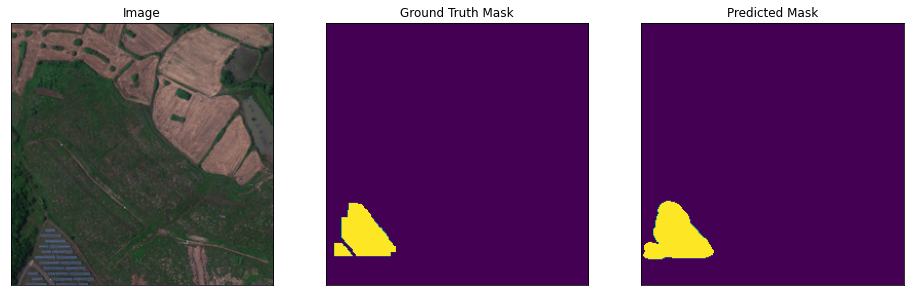

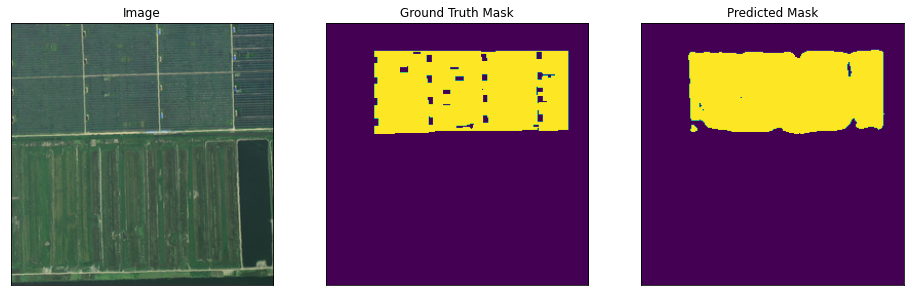

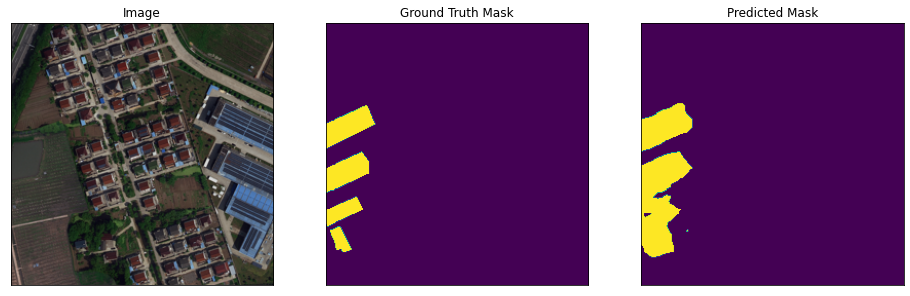

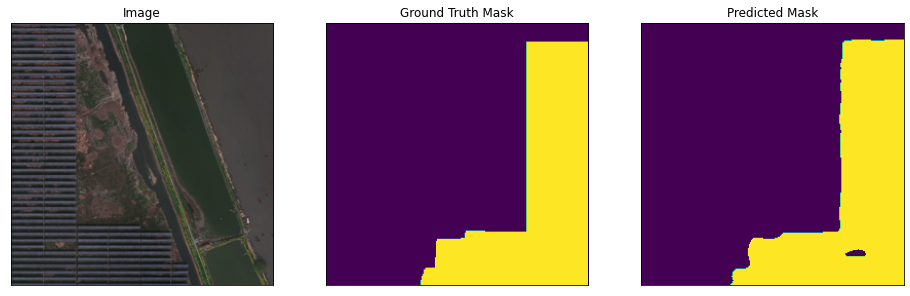

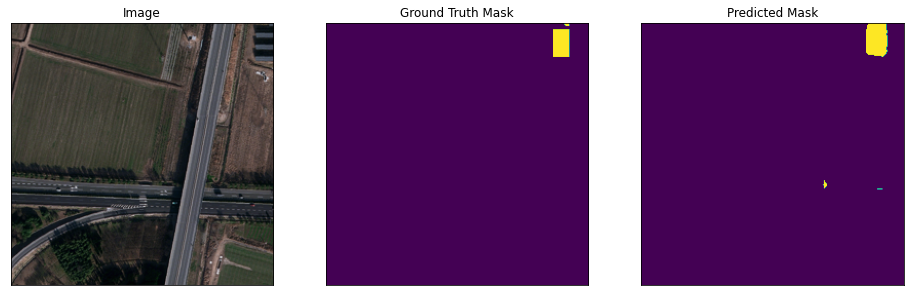

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )